In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
    Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
    Flatten, InputLayer, BatchNormalization, Input,
)
from tensorflow.keras.optimizers import Adam

In [2]:
# NOTE: We don't need to separate x(input) and y(output) for image generation
# since we can use the input image itself to check if the output image is good
# enough.
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# NOTE: We concatenate x_train and x_test because we don't need to separate
# them for image generation (for the same reason stated before).
mnist_digits = np.concatenate([x_train, x_test], axis=0) # 28 x 28
mnist_digits = np.expand_dims(mnist_digits, -1) # 28 x 28 x 1
mnist_digits = mnist_digits.astype("float32") / 255

# Big batch size because the images are very small (28x28).
BATCH_SIZE = 128
# Meaning each image is encoded into a 2D vector (also, it's good for visualization).
LATENT_DIM = 2

# train_dataset = tf.keras.data.Dataset.from_tensor_slices([mnist_digits])
train_dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    # stdder (v) can be written as e^((1/2)logv²)
    # Euler number -> e ~= 2.718281828459045
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))

encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
x = Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)

x = Flatten()(x)
# A Dense(16) layer reduces this high-dimensional vector to a lower-dimensional
# representation with 16 units. This compact representation helps capture the
# most salient features from the flattened input.
x = Dense(16, activation="relu")(x)

# NOTE: We don't use ReLU in any of these two because it could lead
# to exploding/vanishing gradients due to numerical instability.
mean = Dense(LATENT_DIM,)(x)
"""
Variance (σ2) must always be positive, as NEGATIVE variances are mathematically
INVALID. Using log⁡(σ2) avoids the need for constraints because any real
number output from the network can be transformed into a positive variance via
σ2=exp⁡(log⁡(σ2)).
"""
log_var = Dense(LATENT_DIM,)(x)

# The Sampling custom layer performs the `parameterization` trick
# (miu + stdder * epsilon) to allow gradient based optimization for the VAE.
z = Sampling()([mean, log_var])

"""
>> z: The sampled latent variable z is the compressed representation of the
input data in the latent space.
>> mean and log_var: Used for calculating the KL (Kullback-Leibler) divergence
during training.
"""
encoder_model = Model(encoder_inputs, [z, mean, log_var], name="encoder")
encoder_model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
decoder_inputs = Input(shape=(LATENT_DIM,))

# 7 because its multiple of the size of the images (28x28)
x = Dense(7*7*64, activation="relu")(decoder_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)

x = Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)

decoder_model = Model(decoder_inputs, x, name="decoder")
decoder_model.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
vae_inputs = Input(shape=(28,28,1))
# z, mean, log_var -> mean and log_var are only necessary for KL Divergence calculation in the loss.
z, _, _ = encoder_model(vae_inputs)
vae_outputs = decoder_model(z)
vae_model = Model(vae_inputs, vae_outputs, name="variational_autoencoder")
vae_model.summary()

Model: "variational_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
optimizer = Adam(learning_rate=1e-3)
epochs = 20

def custom_loss(y_true, y_pred, mean, log_var):
  reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
  # NOTE: axis=(1,2) because at this point the shape is (B, 28, 28, 1), so we take both 28.
  reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=(1,2))
  reconstruction_loss = tf.reduce_mean(reconstruction_loss)

  regularization_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
  regularization_loss = tf.reduce_sum(regularization_loss, axis=1)
  regularization_loss = tf.reduce_mean(regularization_loss)

  return reconstruction_loss + regularization_loss

def training_block(x_batch, optimizer):
  with tf.GradientTape() as tape:
    z, mean, log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)
  """
  This step leverages the backpropagation algorithm to calculate how much each model weight
  contributed to the loss. These gradients (partial derivatives) are then used to adjust the
  weights during optimization, which helps minimize the loss in future steps.
  """
  # partial derivative of the loss with respect to all weight
  partial_derivatives = tape.gradient(loss, vae_model.trainable_weights)
  optimizer.apply_gradients(zip(partial_derivatives, vae_model.trainable_weights))
  return loss

@tf.function
def custom_vae_training(train_dataset, epochs, optimizer):
  tf.print("Commence training...")

  for epoch in range(1, epochs+1):
    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch, optimizer)
    tf.print(f"epoch[{epoch}] -> loss: {loss}")

  tf.print("Training complete.")

In [7]:
# custom_vae_training(train_dataset, epochs, optimizer)

In [8]:
# vae_model.load_weights("vae_model.weights.h5")

# Visualization

In [9]:
scale = 1
"""
Since the decoder was trained to generate images based on points in the latent
space close to each other, sampling too far from the origin could result in
points that are not well-represented by the decoder, leading to less realistic
or meaningful images.
"""
# scale = 30
n = 16

"""
The latent space might map the digit "0" near the origin, "1" near a nearby
point, and so on. Therefore, by sampling points in this latent space
(via grid_x and grid_y), we are essentially navigating through this learned
representation.
"""
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


In [10]:
# vae_model.save_weights("vae_model.weights.h5")
# vae_model.load_weights("vae_model.weights.h5")

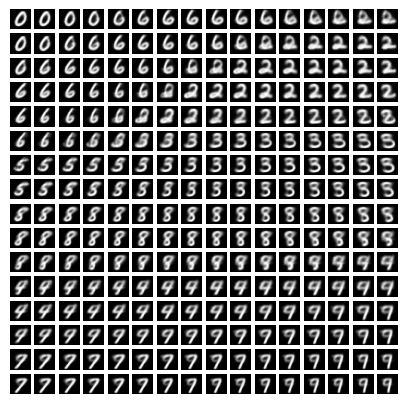

In [19]:
plt.figure(figsize=[5,5])
k = 0
for i in grid_x:
  for j in grid_y:
    """
    When we feed a 2D latent vector like [i, j] (from the grid points) into
    the decoder, it generates an image that corresponds to the position of
    that vector in the latent space.
    """
    # inp (which is z) is a 2D vector which compresses the most
    # important features of the latent space.
    inp = tf.constant([[i,j]])
    # >> vae_model.layers[2] takes only the decoder.
    # >> [0] removes from the batch.
    # >> [..., 0] transforms 28x28x1 into 28x28.
    # out = vae_model.layers[2].predict(inp, verbose=0)[0][..., 0]
    out = model.decoder.predict(inp, verbose=0)[0][..., 0]

    plt.subplot(n, n, k+1)
    plt.imshow(out, cmap="Greys_r")
    plt.axis("off")

    k+=1

# Visualizing Latent Space

In [12]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
# mnist_digits = np.expand_dims(x_train, -1).astype(np.float32) / 255

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


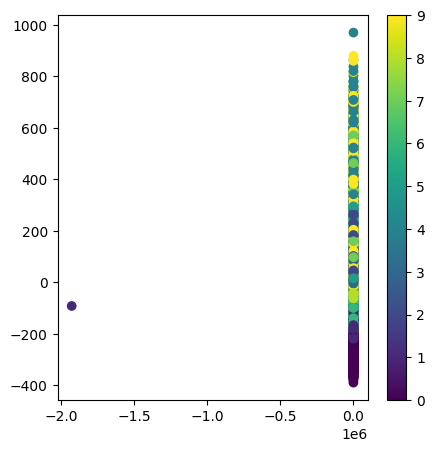

In [18]:
# z, _, _ = vae_model.layers[1].predict(x_train)
z, _, _ = model.encoder.predict(x_train)
plt.figure(figsize=[5,5])
plt.scatter(x=z[:, 0], y=z[:, 1], c=y_train)
plt.colorbar()
plt.show()

# Custom train_step

In [17]:
class VAE(Model):
  def __init__(self, encoder, decoder, custom_loss):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.custom_loss = custom_loss
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self, x_batch):
    with tf.GradientTape() as tape:
      z, mean, log_var = self.encoder(x_batch)
      y_pred = self.decoder(z)
      loss = self.custom_loss(x_batch, y_pred, mean, log_var)
    partial_derivatives = tape.gradient(loss, self.trainable_weights)
    # From model.compile(optimizer=?)
    self.optimizer.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {"loss":self.loss_tracker.result()}

def schedule(epoch, lr):
  if epoch <= 1:
    return 1e-1
  else:
    return 1e-3

lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)

model = VAE(encoder_model, decoder_model, custom_loss)
model.compile(optimizer=Adam(learning_rate=1e-7))
# model.fit(train_dataset, epochs=30, verbose=1, callbacks=[lr_callback])
model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 146.4978
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 146.5074
Epoch 3/100
 21/547 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 142.4199

KeyboardInterrupt: 